# Homework 5: Data from the web
**Date:** 17/12/2024  

## Introduction 
In this assignment, we will gather and analyze data from the internet using REST APIs and web scraping. We will retrieve Nobel Prize data in Physics via an API to analyze prize motivations and scrape book data from a website to compile details like titles, prices, and ratings.

---

## **Contents**  
1. **Retrieving and Visualizing Nobel Prize Data**  
   1.1 Fetching Nobel Prize Data via API  
   1.2 Cleaning and Preprocessing the Data  
   1.3 Generating and Displaying the Word Cloud  

2. **Scraping and Analyzing Book Data**  
   2.1 Extracting Book URLs from Pages     
   2.2 Extracting Book Details     
   2.3 Compiling and Displaying Book Data    





## 1. Retrieving and Visualizing Nobel Prize Data

In this section, we will use the Nobel Prize API to retrieve information about the Nobel Prizes specifically in Physics. Our goal is to extract prize motivations. These motivations will then be processed and visualized using a word cloud.


### 1.1 Fetching Nobel Prize Data via API
We will retrieve Nobel Prize data from the API, filtering for the Physics category. Since the API returns data in batches, multiple requests are made to collect all records. For each prize, we extract the motivation text provided for the laureates. In cases with multiple laureates, where motivations may be identical or slightly different, we select the motivation of the first laureate only.

In [1]:
import requests
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Base API URL and parameters
API_URL = "https://api.nobelprize.org/2/nobelPrizes"
params = {"nobelPrizeCategory": "phy", "offset": 0}
motivations = []

# Fetch all Nobel Prize data with pagination
while True:
    response = requests.get(API_URL, params=params)
    data = response.json()
    prizes = data.get('nobelPrizes', [])
    if not prizes:  # Stop when no more results are returned
        break

    # Extract the first non-empty motivation per prize
    for prize in prizes:
        laureates = prize.get('laureates', [])
        for laureate in laureates:
            motivation = laureate.get('motivation', {}).get('en', "")
            if motivation:  # Append the first valid motivation and break
                motivations.append(motivation)
                break
    
    params["offset"] += len(prizes)  # Increment offset for pagination

# Data inspection
motivations[:3]

['in recognition of the extraordinary services he has rendered by the discovery of the remarkable rays subsequently named after him',
 'in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena',
 'in recognition of the extraordinary services he has rendered by his discovery of spontaneous radioactivity']

### 1.2 Cleaning and Preprocessing the Data
We need to clean and preprocess the data. This involves combining all motivations into a single string, capitalizing words to standardize them, removing punctuation using regular expressions, and eliminating any unnecessary whitespaces. Additionally, stopwords (common words like "the", "in", and "of") are removed to focus on meaningful words that convey the essence of the prize motivations.

In [2]:
# Combine all motivations into a single string
all_text = " ".join(motivations)

# Capitalize all words
all_text = all_text.title()

# Remove punctuation with regex
all_text = re.sub(r'[^\w\s]', '', all_text)

# Splitting on whitespace
words = all_text.split()

# Remove stopwords
stop_words = set(stopwords.words('english'))
clean_words = [word for word in words if word not in stop_words]

clean_text = " ".join(clean_words)

### 1.3 Generating and Displaying the Word Cloud
With the clean text ready, we can generate and display the word cloud. The word cloud visually represents the frequency of words in the text, with more frequent words appearing larger.

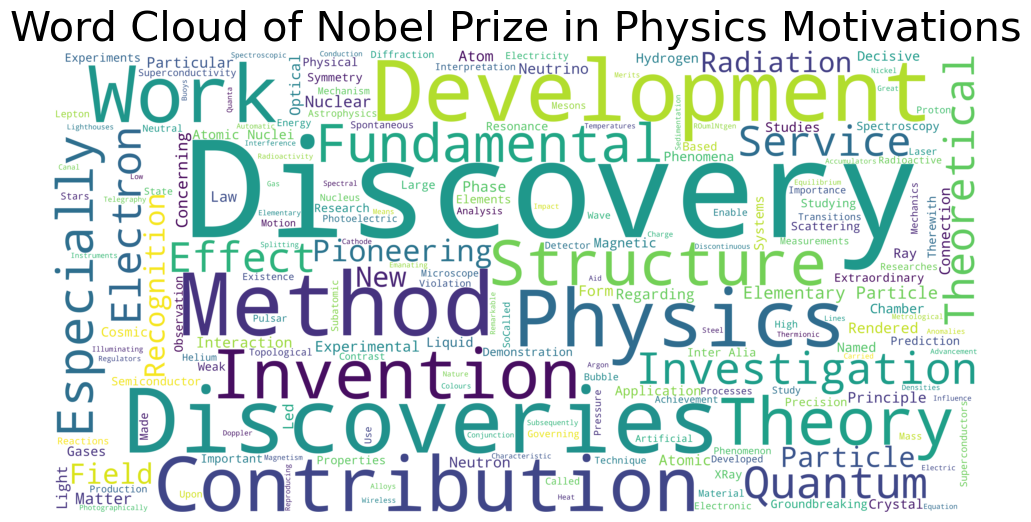

In [8]:
# Creating wordcloud
wordcloud = WordCloud(width=8000, height=4000, colormap='viridis', background_color='white').generate(clean_text)

# Show wordcloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Nobel Prize in Physics Motivations", fontsize=30)
plt.show()

## 2. Scraping and Analyzing Book Data

We will scrape the site (https://books.toscrape.com/) and collect data on books, including their UPC, title, price, and rating. We will scrape 3 pages and put together the data into a structured format. Finally we'll show the final table. 

In [4]:
import requests
from bs4 import BeautifulSoup

BASE_URL = "https://books.toscrape.com/"

### 2.1 Extracting Book URLs from Pages
We define a function to dynamically generate the URLs for different pages. This function will fetch the book links listed on each page.

In [5]:
PAGE_URL = BASE_URL + "catalogue/page-{}.html"
def get_book_links(page_number):
    """
    From given page number
    Returns list: Absolute URLs of books listed on the page.
     """
    url = PAGE_URL.format(page_number)
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "html.parser")
    # Books are listed under article.product_pod
    books = soup.find_all("article", class_="product_pod")
    links = []
    for book in books:
        # Each book link is in h3 > a, with a href value
        href = book.find("h3").find("a")["href"]
        # Make the link absolute
        link = BASE_URL + "catalogue/" + href
        links.append(link)
    return links

### 2.2 Extracting Book Details
Next, we define a function to scrape specific details from each book page, such as its UPC, title, price, and rating.

In [6]:
def get_book_data(book_url):
    """
    From the given book page URL
    Returns dict: 'upc', 'title', 'price', and 'rating' of the book
    """
    r = requests.get(book_url)
    soup = BeautifulSoup(r.content, "html.parser")
    
    # Title at h1
    title = soup.find("h1").get_text(strip=True)
    # Price
    price = soup.find("p", class_="price_color").get_text(strip=True)
    # Ratings in second element
    rating = soup.find("p", class_="star-rating")["class"][1]
    # UPC is in a table 
    table = soup.find("table", class_="table-striped")
    upc = table.find("th", string="UPC").find_next_sibling("td").get_text(strip=True)
    
    return {"upc": upc, "title": title, "price": price, "rating": rating}

### 2.3 Compiling and Displaying Book Data
Finally, we use the above functions to scrape data from the first three pages of the site and display the results in a table.

In [7]:
all_data = []
# We will scrape first three pages
for page in range(1, 4):
    book_links = get_book_links(page)
    for link in book_links:
        book_info = get_book_data(link)
        all_data.append(book_info)
        
df_books = pd.DataFrame(all_data)
df_books.head(5)

,upc,title,price,rating
0,a897fe39b1053632,A Light in the Attic,£51.77,Three
1,90fa61229261140a,Tipping the Velvet,£53.74,One
2,6957f44c3847a760,Soumission,£50.10,One
3,e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4,4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five
